<Figure size 1152x1535.76 with 0 Axes>

<Figure size 1152x1535.76 with 0 Axes>

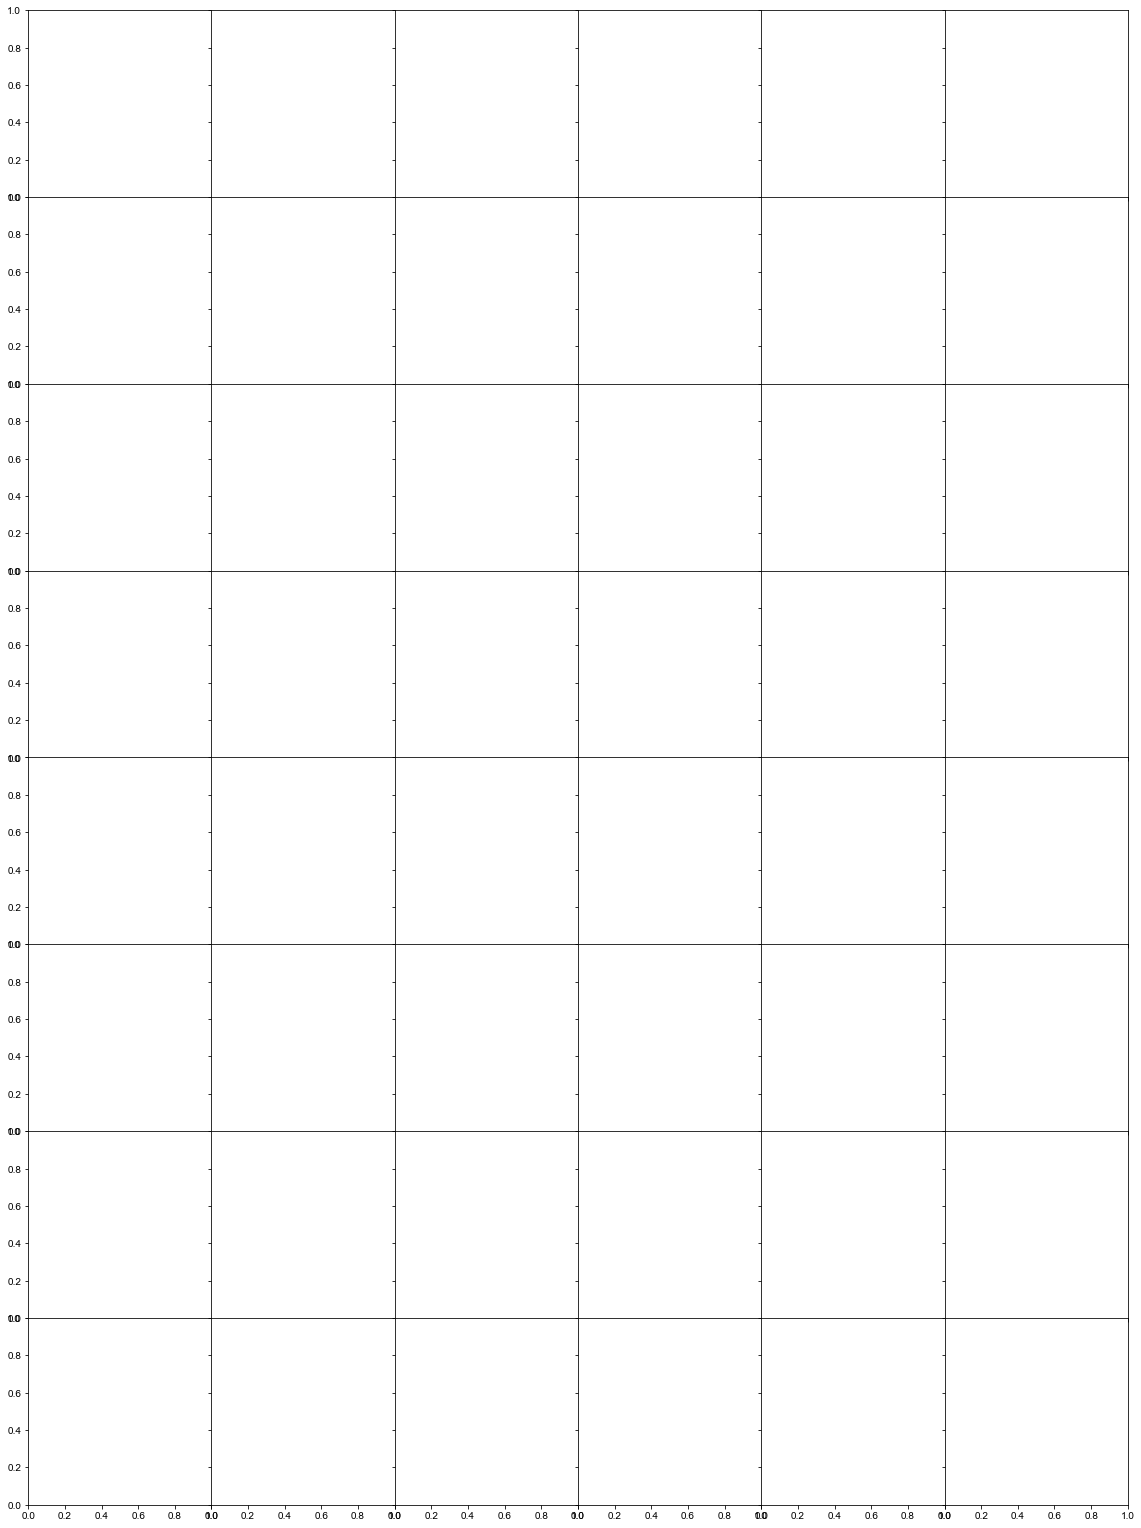

In [1]:
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib.pyplot import MultipleLocator
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import sympy
import warnings
warnings.filterwarnings("ignore")


#width，height，列数,行数,中文1英文0,文件序号,子图序号,当前行，当前列
# FX,FY,NC,NR,CN,NN,index,row,col,fontx = [16,10,4,3,1,0,0,0,0,9]     #PPT 多图 display 4*3
# FX,FY,NC,NR,CN,NN,index,row,col,fontx = [19,9.5,6,3,1,0,0,0,0,9]    #PPT display 6*3
FX,FY,NC,NR,CN,NN,index,row,col,fontx = [16,21.33,6,8,0,0,0,0,0,7]    #单图 
EXT,DPI = ['png',300]  # eps svg pdf jpg png
fig,ax =  plt.subplots(figsize=(FX,FY),ncols=NC,nrows=NR,sharex=False,sharey=False)
xxx = np.linspace(0, 1, 100)   #分别代表最小，最大，数量， 生成一个等差数列
indexs = ['01','02','03','04','05','06','07','08','09','10','11','12',
            '13','14','15','16','17','18','19','20','21','22','23','24',
            '25','26','27','28','29','30','31','32','33','34','35','36',
            '37','38','39','40','41','a1','a2','a3','b1','b2','b3','c1']
best_pdq = pd.read_excel('D:/ee-composite/src/sqlserver/arima/U_best_p_d_q_mse.xlsx')

def fig_clear(cn=CN):
    plt.clf()
    global NN,fig,ax
    fontname = 'SimHei' if cn>0 else 'Arial'
    plt.rcParams['font.sans-serif'] = [fontname]
    plt.rcParams['axes.unicode_minus'] = False
    fig,ax =  plt.subplots(figsize=(FX,FY),ncols=NC,nrows=NR,sharex=True,sharey=True)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    NN +=1

def plot_cell(data,lbl,isEnding=0):
    global index, row, col, ax
    index2 = index if index<NC*NR else (index % (NC*NR))
    row = index2 // NC
    col = index2 % NC
    axx = ax[row][col]
    # print(index,index2,row,col)

    e = data['E']
    u = data['U']
    fit = np.polyfit(u,e,2)
    ef = u**2*fit[0]+u*fit[1]+fit[2]
    ccd = 0.5+0.5*(np.sqrt(ef**2+u**2) - np.sqrt((ef-1)**2+(u-1)**2))/np.sqrt(2)
    fit2 = np.polyfit(u,ccd,2)
    fitted = xxx**2*fit2[0]+xxx*fit2[1]+fit2[2]

    best_pdqline = best_pdq.query('i=='+str(index)).values[0][3:6]
    p,d,q = best_pdqline
    model = ARIMA(u, order=(p,d,q))  
    fittedmodel = model.fit()
    fc = fittedmodel.get_prediction(start=36,end=45,dynamic=False)
    predicted = fc.predicted_mean
    predicted_ccd = predicted**2*fit2[0]+predicted*fit2[1]+fit2[2]

    minvspan = u.max()
    x = sympy.symbols('x')
    maxv = sympy.solve([x**2*fit2[0]+x*fit2[1]+fit2[2]-fitted.max()],[x])
    maxvspan = 1 if fit2[0]>0 else maxv[0][0]
    colorvspan = 'tab:red' if minvspan>maxv[0][0] and fit2[0]<0 else 'tab:green'
    saturationx = maxvspan
    saturationy = fitted.max()
    saturationpx = saturationx+0.02 if saturationx<0.65 else saturationx-0.28
    saturationpy = saturationy+0.02 if saturationy<0.8 else saturationy-0.05

    axx.xaxis.set_major_locator(MultipleLocator(0.2))
    axx.xaxis.set_minor_locator(MultipleLocator(0.1))
    axx.yaxis.set_major_locator(MultipleLocator(0.2))
    axx.yaxis.set_minor_locator(MultipleLocator(0.1))
    axx.tick_params(which='major',direction='in', length=6)
    axx.tick_params(which='minor',direction='in', length=4,width=0.5)
    axx.tick_params(direction='in', length=3, width=1)
    axx.text(0.97,0.965, indexs[index], fontsize='12',fontweight='bold',
                        horizontalalignment='right',verticalalignment='top',
                        transform = axx.transAxes,backgroundcolor='lightgray',
                        fontfamily='sans-serif',zorder=100)
    axx.text(0.36,0.12,r'$E={:.3f}U^2{:+.3f}U{:+.3f}$'.format(fit[0],fit[1],fit[2]), fontsize=fontx,zorder=999)
    axx.text(0.36,0.05,r'$C={:.3f}U^2{:+.3f}U{:+.3f}$'.format(fit2[0],fit2[1],fit2[2]), fontsize=fontx,zorder=999)
    axx.text(saturationpx,saturationpy,r'$({:.3f},{:.3f})$'.format(saturationx,saturationy), fontsize=fontx,zorder=999)
    
    L1,=axx.plot(u,ccd,'ko',lw=1,label=lbl,markerfacecolor='none')
    L2,=axx.plot(xxx,fitted,color='tab:blue',label='Fitting curve',lw=2)
    L3,=axx.plot([saturationx],[saturationy],'ro',label='Saturation',lw=20)
    L4,=axx.plot(predicted,predicted_ccd,'o',color='tab:green',label='Prediction',lw=1,markerfacecolor='tab:green')
    axx.legend(handles=[L1, L2, L3,L4], loc="upper left", ncol=1)
    axx.axvline(x=maxvspan, color='tab:red', linestyle='--',linewidth=1,zorder=100)
    axx.axvspan(xmin=minvspan, xmax=maxvspan, ymin=0, ymax=1,color=colorvspan,alpha=0.15)

    index +=1
    if (row==NR-1 and col==NC-1) or isEnding==1:
        plt.setp(ax[:, :], xlim=[0, 1])
        plt.setp(ax[:, :], ylim=[0, 1])
        plt.setp(ax[-1, :], xlabel='Urbanization')
        plt.setp(ax[:, 0], ylabel='CCD')
        plt.savefig(fname="predicted-C-U-"+str(DPI)+"-"+str(NN)+'.'+EXT,format=EXT, dpi=DPI,pad_inches=0,transparent=True,facecolor='w')
        fig_clear(CN)

## prepare data
E = pd.read_excel('D:/ee-composite/src/sqlserver/data/E/Data_E_1_PC1.xlsx').rename(columns={'pc1':'E'})
U = pd.read_excel('D:/ee-composite/src/sqlserver/data/U/Data_U_1_PC1.xlsx').rename(columns={'pc1':'U'})
df = pd.concat([E,U['U']],axis=1)
fig_clear(CN)

######### Citys
for i in range(1,42,1):
    tmp = df.query('sn=='+str(i))
    lbl = tmp.iat[0,3] if CN>0 else tmp.iat[0,2]
    plot_cell(tmp,lbl)

######### Provinces
for i,item in enumerate(['Anhui','Jiangsu','Zhejiang']):
    tmp = df.query('province=="'+ item +'"').groupby(by='year').mean()
    lbl = item
    plot_cell(tmp,lbl)
    
######### City types   
for i,item in enumerate(['Magecity','Super city','Large city']):
    tmp = df.query('classid=='+str(i+1)).groupby(by='year').mean()
    plot_cell(tmp,item)

######### study area
tmp = df.groupby(by='year').mean()
plot_cell(tmp,'Study Area',isEnding=1)